# Projet d'intelligence artificielle par Lucas Heidet
Cours d'intelligence artificielle du Cégep de Matane 

[Lien Github du projet](https://github.com/cegepmatane/projet-intelligent-LucasH)


Utilise le dataset [speech commands](https://arxiv.org/abs/1804.03209) par P. Warden, Avril 2018. Mini version par Tensorflow, téléchargeable [ici](http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip).

---
# Présentation du projet
Le but du projet est d'entrainer un [réseau de neuronnes convolutif](https://www.tensorflow.org/tutorials/images/cnn?hl=en) capable de reconnaître des commmandes vocales simples. Dans le futur, l'objectif est d'utiliser le modèle entraîné dans une application android relié à un robot Arduino.

En utilisant le dataset `mini_speech_commands`, notre modèle devra être capable de reconnaître les 8 commandes suivantes : 
```
Commandes: ['down' 'left' 'go' 'right' 'yes' 'up' 'no' 'stop']
```

Les commandes sont des fichiers pré-formatés en `.wav` de 1 seconde, répartis dans les dossiers correspondants à ce qu'ils représentent.

# Setup des librairies utilisées
Ici nous allons importer toutes les librairies que nous allons utiliser pour ce projet.

**Utilité des librairies :**
* **os :** nécessaire pour la manipulation de fichiers
* **pathlib :** utilisé pour stocker le dataset à l'endroit souhaité
* **pyplot :** utilisé pour dessiner les différents graphes pour le projet
* **numpy :** utilisé pour faire des manipulations de tableaux
* **librosa :** utilisé pour extraire les features des fichiers audios
* **tensorflow :** utilisé pour créer et entraîner le modèle
* **IPython :** utilisé pour nous permettre d'écouter les fichiers audios

In [1]:
! pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split

from IPython import display as ipd

# Téléchargement du dataset

In [3]:
CHEMIN_DATASET = "donnees/mini_speech_commands"

rep_donnees = pathlib.Path(CHEMIN_DATASET)
if not rep_donnees.exists() :
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='donnees')


182082353/182082353 [==============================] - 1s 0us/step


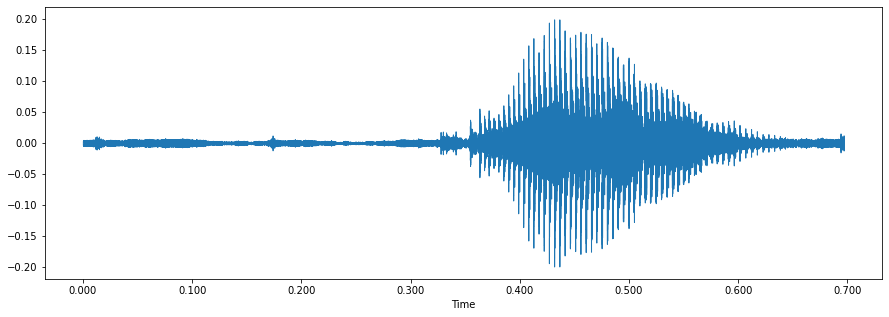

In [4]:
# Petit apperçu d'un des fichiers du data set
fnom = "/content/donnees/mini_speech_commands/go/004ae714_nohash_0.wav"
donnee, freq_sample = librosa.load(fnom)
plt.figure(figsize=(15,5))
librosa.display.waveshow(donnee, sr=freq_sample)
ipd.Audio(fnom)

# Préparation des classes

In [5]:
commandes = np.array(tf.io.gfile.listdir(str(rep_donnees)))
commandes = commandes[commandes != 'README.md']
print('Commandes:', commandes)

Commandes: ['left' 'up' 'go' 'stop' 'no' 'right' 'yes' 'down']


# Préparation des données

In [6]:
# nombres samples dans 1 sec d'audio
ECH_A_TRAITER = 22050

# fonction pour charger les données et les retourner sous forme de Map
def charger_donnees():
  donnees = {
      "mapping": [],
      "labels": [],
      "MFCCs" : [],
      "fichiers": []
  }

  # passer dans tous les dossiers
  for i, (chemDos, nomDos, nomFich) in enumerate(os.walk(CHEMIN_DATASET)):

    # assure qu'on est pas à la racine du dataset
    if chemDos is not CHEMIN_DATASET:
      # mets le label dans le mapping
      label = chemDos.split("/")[-1]
      donnees["mapping"].append(label)
      print("\nTraitement : '{}'".format(label))

      # traite tous les fichiers du dossier du label et stocke les MFCCs
      for f in nomFich:
        chemFich = os.path.join(chemDos, f)

        # charge le fichier audio et le traite avec librosa
        signal, freq_sample = librosa.load(chemFich)

        # laisse les audios avec moins de une seconde d'échantillons
        if len(signal) >= ECH_A_TRAITER:

          # remplis le manque
          signal = signal[:ECH_A_TRAITER]

          # extraire les MFCCs
          MFCCs = librosa.feature.mfcc(signal, freq_sample, n_mfcc=13, n_fft=2048, hop_length=512)

          # stock les données reçues
          donnees["MFCCs"].append(MFCCs)
          donnees["labels"].append(i-1)
          donnees["fichiers"].append(chemFich)
          print("{} : {}".format(chemFich, i-1))

  return donnees

In [7]:
dataset = charger_donnees() #prend 3-4 min à s'exécuter

# répartis les données des MFCCs et de labels
X = np.array(dataset["MFCCs"])
y = np.array(dataset["labels"])

# split les données en données d'entraînement, test et validation
donnees_entrainement, donnees_test, labels_entrainement, labels_test = train_test_split(X, y, test_size=0.2)
donnees_entrainement, donnees_validation, labels_entrainement, label_validation = train_test_split(donnees_entrainement, labels_entrainement, test_size=0.2)

# ajoute une dimension
donnees_entrainementCnn = np.expand_dims(donnees_entrainement, axis=2)
donnees_testCnn = np.expand_dims(donnees_test, axis=2)

print(donnees_entrainementCnn.shape, donnees_testCnn.shape)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
donnees/mini_speech_commands/go/3fb8c268_nohash_0.wav : 2
donnees/mini_speech_commands/go/70a00e98_nohash_3.wav : 2
donnees/mini_speech_commands/go/da15e796_nohash_0.wav : 2
donnees/mini_speech_commands/go/620ff0fa_nohash_1.wav : 2
donnees/mini_speech_commands/go/3402e488_nohash_2.wav : 2
donnees/mini_speech_commands/go/6c968bd9_nohash_4.wav : 2
donnees/mini_speech_commands/go/3983ba0d_nohash_0.wav : 2
donnees/mini_speech_commands/go/fb9d6d23_nohash_1.wav : 2
donnees/mini_speech_commands/go/96a48d28_nohash_0.wav : 2
donnees/mini_speech_commands/go/c0c701f1_nohash_1.wav : 2
donnees/mini_speech_commands/go/ffd2ba2f_nohash_2.wav : 2
donnees/mini_speech_commands/go/c0445658_nohash_0.wav : 2
donnees/mini_speech_commands/go/026290a7_nohash_0.wav : 2
donnees/mini_speech_commands/go/8f4c551f_nohash_4.wav : 2
donnees/mini_speech_commands/go/3c6d55b3_nohash_1.wav : 2
donnees/mini_speech_commands/go/825f450d_nohash_0.wa

In [8]:
print(donnees_entrainement.shape[1], donnees_entrainement.shape[2], 1)

13 44 1


# Visualisation des MFCCs

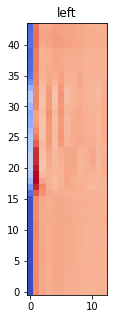

In [9]:
from matplotlib import cm
fig, ax = plt.subplots(figsize=(15,5))
mfcc_data= np.swapaxes(X[0], 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
ax.set_title(dataset['mapping'][0])

plt.show()

# Création du modèle CNN

In [39]:
# Création du modèle
def construct_modele(input_shape, nbr_labels):
  modele = models.Sequential()

  # première couche de convolution
  modele.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape))
  modele.add(layers.BatchNormalization())
  modele.add(layers.MaxPooling2D((3,3), strides=(2,2), padding='same'))

  # deuxième couche de convolution
  modele.add(layers.Conv2D(32, (3,3), activation='relu'))
  modele.add(layers.BatchNormalization())
  modele.add(layers.MaxPooling2D((3,3), strides=(2,2), padding='same'))

  # troisieme couche de convolution
  modele.add(layers.Conv2D(32, (2,2), activation='relu'))
  modele.add(layers.BatchNormalization())
  modele.add(layers.MaxPooling2D((2,2), strides=(2,2), padding='same'))

  # applatir la sortie dans une couche Dense
  modele.add(layers.Flatten())
  modele.add(layers.Dense(64, activation='relu'))
  layers.Dropout(0.3)

  # couche de sortie Softmax
  modele.add(layers.Dense(nbr_labels, activation='softmax'))

  # Compilation du modele
  modele.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy']
                 )
  
  # Sommaire du modele
  modele.summary()

  return modele

(13, 44, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 11, 42, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 11, 42, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 21, 64)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 19, 32)         18464     
                                                                 
 batch_normalization_1 (Batc  (None, 4, 19, 32)        128       
 hNormalization)                                                 
                                            

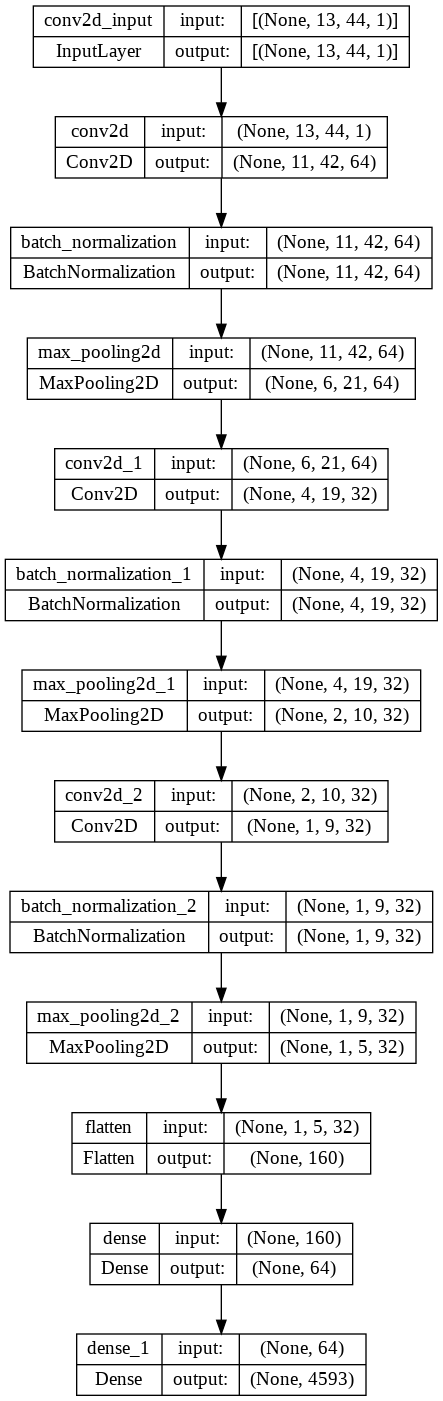

In [40]:
input_shape = (donnees_entrainementCnn.shape[1], donnees_entrainementCnn.shape[3], 1)
print(input_shape)
nbr_labels = len(labels_entrainement)

modele = construct_modele(input_shape, nbr_labels)

tf.keras.utils.plot_model(modele,
                          show_shapes=True,
                          show_layer_names=True)

# Entrainement du modèle

In [41]:
# stocke les traces de l'entrainement
callback_stop_avant_fin = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=5)
historique = modele.fit(donnees_entrainement, 
                        labels_entrainement,
                        epochs=40,
                        batch_size=32,
                        validation_data=(donnees_validation, label_validation),
                        callbacks=[callback_stop_avant_fin])


Epoch 1/40


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


144/144 [==============================] - 12s 73ms/step - loss: 2.7701 - accuracy: 0.3660 - val_loss: 1.4784 - val_accuracy: 0.4021
Epoch 2/40
144/144 [==============================] - 10s 70ms/step - loss: 0.8624 - accuracy: 0.7189 - val_loss: 1.0463 - val_accuracy: 0.6171
Epoch 3/40
144/144 [==============================] - 10s 66ms/step - loss: 0.5592 - accuracy: 0.8152 - val_loss: 0.7493 - val_accuracy: 0.7241
Epoch 4/40
144/144 [==============================] - 13s 94ms/step - loss: 0.4037 - accuracy: 0.8663 - val_loss: 0.8207 - val_accuracy: 0.7337
Epoch 5/40
144/144 [==============================] - 11s 75ms/step - loss: 0.3272 - accuracy: 0.8916 - val_loss: 0.6676 - val_accuracy: 0.7981
Epoch 6/40
144/144 [==============================] - 10s 67ms/step - loss: 0.2934 - accuracy: 0.9005 - val_loss: 0.3935 - val_accuracy: 0.8747
Epoch 7/40
144/144 [==============================] - 9s 66ms/step - loss: 0.2319 - accuracy: 0.9264 - val_loss: 0.3174 - val_accuracy: 0.8956
Epoc

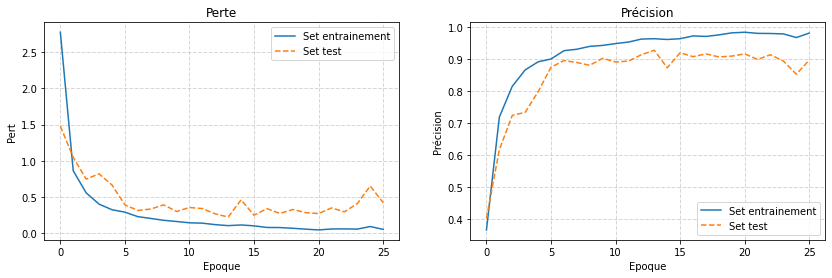

In [44]:
# permet d'afficher les courbes de l'entrainement
def afficher_historique_entrainement(historique_entrainement):
    loss = historique_entrainement.history['loss']
    val_loss = historique_entrainement.history['val_loss']

    accuracy = historique_entrainement.history['accuracy']
    val_accuracy = historique_entrainement.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Perte')
    plt.xlabel('Epoque')
    plt.ylabel('Pert')
    plt.plot(loss, label='Set entrainement')
    plt.plot(val_loss, label='Set test', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Précision')
    plt.xlabel('Epoque')
    plt.ylabel('Précision')
    plt.plot(accuracy, label='Set entrainement')
    plt.plot(val_accuracy, label='Set test', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

afficher_historique_entrainement(historique)


# Matrice de confusion

Évaluation du modèle...
Exactitude test: 88.09%
36/36 [==============================] - 1s 16ms/step


<function matplotlib.pyplot.show(*args, **kw)>

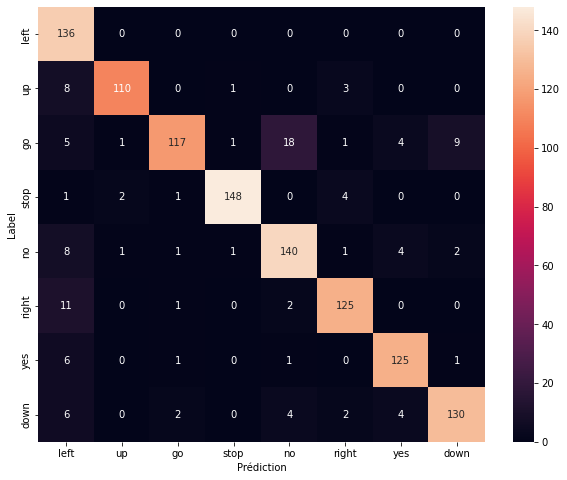

In [45]:
import seaborn as sns
# Evaluation du modèle
print("Évaluation du modèle...")

resultats = modele.evaluate(donnees_test, labels_test, verbose=0)
print("Exactitude test: {:.2f}%".format(resultats[1]*100))

# predictions
pred_y = modele.predict(donnees_validation)
pred_y = tf.argmax(pred_y, axis=1)
vrai_y = label_validation

mtx_confusion = tf.math.confusion_matrix(vrai_y, pred_y)
plt.figure(figsize=(10,8))
sns.heatmap(mtx_confusion,
            xticklabels=commandes,
            yticklabels=commandes,
            annot=True, fmt='g')
plt.xlabel('Prédiction')
plt.ylabel('Label')
plt.show

# Calcul de sensibilité et spécificité

In [46]:
vrai_positif = 0
vrai_negatif = 0
faux_positif = 0
faux_negatif = 0
predictions = pred_y

for i in range(len(predictions)):
  if predictions[i] == 1 and vrai_y[i] == 1:
    vrai_positif += 1
  elif predictions[i] == 0 and vrai_y[i] == 0:
    vrai_negatif += 1
  elif predictions[i] == 1 and vrai_y[i] == 0:
    faux_positif += 1
  elif predictions[i] == 0 and vrai_y[i] == 1:
    faux_negatif += 1

print("Vrais positifs : " + str(vrai_positif))
print("Faux posifits : " + str(faux_positif))
print("Vrai négatifs : " + str(vrai_negatif))
print("Faux négatifs : " + str(faux_negatif))

sensibilite = vrai_positif / (vrai_positif + faux_negatif)
specificite = vrai_negatif / (vrai_negatif + faux_positif)

print("Sensibilité : {:.2f}".format(sensibilite))
print("Specificité : {:.2f}".format(specificite))

Vrais positifs : 110
Faux posifits : 0
Vrai négatifs : 136
Faux négatifs : 8
Sensibilité : 0.93
Specificité : 1.00


Valeurs de sensibilité/spécifiité sur 3 essais :
* 0.98/0.97
* 0.98/0.98
* 0.93/1.00

# Exporter le modèle

In [32]:
# modele.save("modele.h5")
# modele.save("modele2.h5")
modele.save("modele3.h5")

In [38]:
# reset le modèle pourles différents essais
tf.keras.backend.clear_session()

# Prédire des fichiers

In [67]:
import random

# modele = tf.keras.models.load_model("modele.h5")

index_random = random.randint(0, len(X)-1)
MFCCs_fichier_random = X[index_random]
MFCCs_fichier_random = MFCCs_fichier_random[np.newaxis,..., np.newaxis]
print(MFCCs_fichier_random.shape)

pred_random = modele.predict(MFCCs_fichier_random)
index_predit = np.argmax(pred_random)
label_predit = dataset["mapping"][index_predit]
print("Prédiction : " + str(label_predit))
ipd.Audio(dataset["fichiers"][index_random])

['left', 'up', 'go', 'stop', 'no', 'right', 'yes', 'down']
(1, 13, 44, 1)
1/1 [==============================] - 0s 32ms/step
Prédiction : stop
